# Task 2: Some Simple Spin Glasses

We'll now investigate some simple spin glasses. Your goal is to devise a thermal annealing schedule to find the ground state of the given Ising Hamiltonian.

In [1]:
import numpy as np
from ising_animator import IsingAnimator
from abstract_ising import AbstractIsing
import matplotlib.pyplot as plt
import random

%matplotlib inline

## 1D Random Bond Ising on a Periodic Chain

$$H = J \sum_{\langle ij \rangle} B_{ij} \sigma_i \sigma_j$$

where $B_{ij} = \pm 1$ which is selected randomly and independently for each bond nearest neighbour bond $ij$ when the model is initialized.

Due to the intrinsic randomness of the Hamiltonian parameters, it is generally quite difficult to find the ground state of this model. 

In [2]:
class RandomBondIsing1DPBC(AbstractIsing):
    def __init__(self, N, J=1.):
        self.J, self.N = J, N
        self.num_spins = self.N
        
        self.bonds = 2*(np.random.rand(self.N) < 0.5) - 1
        
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.N) < 0.5) - 1
    
    def energy(self, spins=None):
        """Returns the energy of the current spin configuration"""
        spins = self.spins if spins is None else spins
        interactions = self.bonds * spins * np.roll(spins, 1, axis=-1)
        total = self.J * np.sum(interactions, axis=-1)
        return total

    def energy_diff(self, i):
        """Returns the energy difference resulting from flipping the i'th site"""
        # sum the nearest neighbour sites
        
        nn_sum = (
            self.bonds[i] * self.spins[i-1] 
            + self.bonds[(i+1)%self.N] * self.spins[(i+1) % self.N] 
        )

        return -2 * self.J * self.spins[i] * nn_sum
    
    def rand_site(self):
        """Selects a site in the lattice at random"""
        return (np.random.randint(self.N),)

In [3]:
ising = RandomBondIsing1DPBC(10, J=1)
ising.spins

array([-1, -1,  1,  1, -1, -1, -1,  1, -1, -1])

In [4]:
ising.bonds

array([-1, -1,  1,  1,  1,  1,  1,  1, -1, -1])

In [5]:
ising.energy()

-2

In [6]:
# perform 1000 MC steps
for t in range(1000):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=1.0)
    
    if t % 50 == 0:
        print(E)

-6
-10
-6
-6
-10
-10
-6
-6
-10
-10
-10
-10
-6
-10
-6
-10
-6
-6
-10
-10


In [7]:
ising.spins

array([ 1,  1, -1,  1, -1,  1, -1,  1,  1,  1])

In [8]:
T = 1.0
n_steps = 1000

[ 1 -1 -1  1  1 -1  1 -1  1 -1]


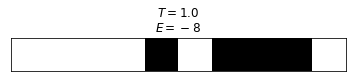

In [9]:
# reinitialize so we're back at a T=infinity state
ising = RandomBondIsing1DPBC(10, J=1)
print(ising.spins)  # print the starting configuration

# NOTE: sometimes the animation gets stuck displaying a single image
# The most reliable way to fix this is by restarting the notebook.
# Initializing the Ising Model in the same cell as the one where you
# run the animation also seems to work.
IsingAnimator(ising).run_animation([T] * n_steps)

In [10]:
def get_bf_min(ising):
    assert ising.num_spins <= 23, "Woah hold up there... You can't do brute force with that many spins."
    dim = np.arange(2 ** ising.num_spins)
    space = ((dim[:, None] & (1 << np.arange(ising.num_spins))) > 0) # very cheeky...
    space = 2*space.astype(int) - 1
    return ising.energy(space).min()

Now of course, we're limited in the size of the systems for which we can compute this energy exactly, hence why we need an annealing procedure which (we hope) would help us find the ground state of the Ising model of interest (or at least a state that is close enough).

Your task is to come up with an annealing procedure to help find the ground state (or something close enough) of this model for several different chain sizes: 10, 20, 50, 100.

For the small systems, compute the ground state energy exactly, and compare it to the result of your annealer.

Since it's impossible to find the exact ground state for large systems, you will be evaluated on your algorithm's performance on the small systems, as well as the overall ingenuity of your method.

In [11]:
def plot_schedule(T):
    t = range(len(T))
    plt.plot(t, T)
    plt.title("Temperature schedule")
    plt.ylabel("$T$")
    plt.xlabel("time");


def create_fixed_schedule(num_steps, T_i, T_f=1.0, form='const', show=True):
    implemented = [
        'const', # constant
        'exp', # exp decay
    ]
    assert form in implemented, f"form='{form}' not implemented"
    if form == 'const':
        T = [T_i] * num_steps
    elif form == 'exp':
        t = np.arange(num_steps+1)
        T = T_i * ((T_f/T_i) ** (t/num_steps))
    if show:
        plot_schedule(T)
    return T
        

def run_mc(num_spins, num_steps, T):
    ising = RandomBondIsing1DPBC(num_spins, J=1.)
    # get minimum energy by brute force (for small enough systems)
    if num_spins <= 23:
        bf_min = get_bf_min(ising)
        print(f"Minimum energy found by brute force: {bf_min}")
    # perform MC steps
    Es = []
    for t in range(num_steps):
        # take a look at the abstract_ising.py file to see how mc_step works
        E = ising.mc_step(T=T[t])
        Es.append(E)
        if t % 100 == 0:
            print(E)
    print(f"Minimum energy found by MC: {min(Es)}")

Minimum energy found by brute force: -8.0
-4.0
-8.0
-4.0
-4.0
-8.0
-8.0
-8.0
-8.0
-8.0
-8.0
Minimum energy found by MC: -8.0


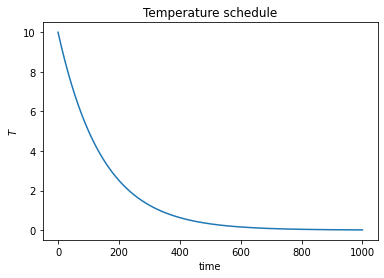

In [12]:
# with 1000 steps, exp decay seems to find the minimum possible energy for all suggested chain sizes
# to clarify, the minimum possible energy is just -N where N is the number of spins
# you can't always hit it because it also depends on the bond configuration
n_spins = 10
num_steps = 1000
T = create_fixed_schedule(num_steps, T_i=10, T_f=0.01, form='exp')
run_mc(n_spins, num_steps, T)

# Fully Connected Random Bond Ising

The Fully Connected Random Bond Ising Hamiltonian takes the form:

$$H = J \sum_{i<j} B_{ij} \sigma_i \sigma_j$$

where $B_{ij} = \pm 1$ which is selected randomly (uniformly) and independently for each bond $ij$ when the model is initialized.

In [13]:
class FullyConnectedRandomBondIsing(AbstractIsing):
    def __init__(self, N, J=1.):
        self.J, self.N = J, N
        self.num_spins = self.N
        
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.N) < 0.5) - 1
    
        self.bonds = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(i+1, self.N):
                self.bonds[i, j] = 2*(np.random.rand() < 0.5) - 1
    
    def energy(self):
        """Returns the energy of the current spin configuration"""
        interaction = self.spins.dot(self.bonds.dot(self.spins))
        return self.J * interaction

    def energy_diff(self, i):
        """Returns the energy difference resulting from flipping the i'th site"""
        return -2 * self.J * self.spins[i] * (
            self.bonds[i, :].dot(self.spins) 
            + self.bonds[:, i].dot(self.spins)
        )
    
    def rand_site(self):
        """Selects a site in the lattice at random"""
        return (np.random.randint(self.N),)

In [14]:
ising = FullyConnectedRandomBondIsing(10, J=1)
ising.spins

array([-1, -1, -1, -1,  1,  1, -1,  1, -1,  1])

In [15]:
ising.energy()

-1.0

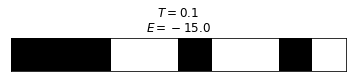

In [16]:
T = 0.1
IsingAnimator(ising).run_animation([T] * n_steps)

In [17]:
ising.energy()

-15.0

In [18]:
def get_bf_min(ising):
    assert ising.num_spins <= 23, "Woah hold up there... You can't do brute force with that many spins."
    dim = np.arange(2 ** ising.num_spins)
    space = ((dim[:, None] & (1 << np.arange(ising.num_spins))) > 0)
    space = 2*space.astype(int) - 1
    return np.einsum("bi,ij,bj->b", space, ising.bonds, space).min()
get_bf_min(ising)

-17.0

Repeat the previous problem with the Fully Connected Random Bond Ising Model for the same system sizes (10, 20, 50, 100).

We ended up playing around a lot with static and dynamic schedules. Most of it didn't yield improvements. Apologies in advance for the messy code!

In [19]:
def plot_schedule(T):
    t = range(len(T))
    plt.plot(t, T)
    plt.title("Temperature schedule")
    plt.ylabel("$T$")
    plt.xlabel("time");
    plt.show()

# this is for all static annealing schedules
def create_fixed_schedule(num_steps, T_i, T_f=1.0, form='const', cycle={}, show=True):
    """
    we found linear decay is quite useless
    also experimented with adding a exp(sin(t)) multiplier onto the baseline schedule
    """
    implemented = [
        'const', # constant
        'exp', # exponential decay
        'lin', # linear decay
    ]
    assert form in implemented, f"form='{form}' not implemented"
    t = np.arange(num_steps+1)
    if form == 'const':
        T = [T_i] * num_steps
    elif form == 'exp':
        T = T_i * ((T_f/T_i) ** (t/num_steps))
    elif form == 'lin':
        T = T_i + (T_f - T_i) * (t/num_steps)
    if len(cycle):
        amp = cycle['amp']
        period = cycle['p']
        cyc = amp * np.sin(2*np.pi*np.arange(len(T))/period)
        T = T * np.exp(cyc)
    if show:
        plot_schedule(T)
    return T


# this is a dynamic annealing schedule
def anneal_on_plateau(T, Es, factor=0.99, patience=10, delta = 1):
    """
    if energy is not improving for patience number of steps, multiply T by a factor (<1)
    """
    if len(Es) > patience:
        best = min(Es[:-patience])
        if Es[-1] - best >= delta:
            T *= factor
    return T


# this is a dynamic annealing schedule
def greener_grass(T, Es, patience=100, delta = 20):
    """
    The grass is greener on the other side
    Jump out of local minimums to find greener grass
    This is kind of like the opposite of anneal on plateau, but it's intended to be used with an
    order of magnitude longer patience
    """
    if len(Es) > patience:
        best = min(Es[-patience:])
        worst = max(Es[-patience:])
        if worst - best < delta:
            T *= np.random.uniform(2,8)
    return T


# this is a dynamic annealing schedule
def gradient_based(T, Es, history=100):
    """
    apply linear fit to history
    if the slope is zero, we want to be annealing T exponentially at some rate
    more negative slope means anneal T more slowly, or maybe even increase it
    more positive slope means T needs to be decreased faster
    The idea is that we try to let the process explore an "interesting" level of T for a while before settling down
    """
    bias = - 0.008
    if len(Es) >= history:
        slope = np.polyfit(range(history), Es[-history:], 1)[0]
        T *= (np.exp(-slope/300) + bias)
    return T


def plot_energy(Es):
    plt.plot(Es)
    plt.title("Energy")
    plt.ylabel("$E$")
    plt.xlabel("time");
    plt.show()

    
def plot_temps(Ts):
    plt.plot(Ts)
    plt.title("Temperature (anneal on plateau)")
    plt.ylabel("$T$")
    plt.xlabel("time");
    plt.show()

    
def run_mc(num_spins, num_steps, T, do_anneal_on_plateau=False, do_greener_grass=False, do_gradient_based=False, verbose=False):
    """
    Runs MC with either a static T schedule, or a dynamic one
    careful, you can't do all combinations of dynamic annealing, see the if block
    """
    ising = FullyConnectedRandomBondIsing(num_spins, J=1.)
    # get minimum energy by brute force (for small enough systems)
    if num_spins <= 23:
        bf_min = get_bf_min(ising)
        print(f"Minimum energy found by brute force: {bf_min}")
    # perform MC steps
    Es = []
    if do_anneal_on_plateau or do_greener_grass or do_gradient_based:
        Ts = [T]
    for t in range(num_steps):
        # DYNAMIC ANNEALING
        if do_anneal_on_plateau and do_greener_grass:
            E = ising.mc_step(T=T)
            T = anneal_on_plateau(T, Es)
            if t % 200 == 0:
                T = greener_grass(T, Es)
            Ts.append(T)
        elif do_anneal_on_plateau:
            E = ising.mc_step(T=T)
            T = anneal_on_plateau(T, Es)
            Ts.append(T)
        elif do_greener_grass:
            E = ising.mc_step(T=T)
            T *= 0.993 # some default decay rate
            if t % 200 == 0:
                T = greener_grass(T, Es)
            Ts.append(T)
        elif do_gradient_based:
            E = ising.mc_step(T=T)
            T = gradient_based(T, Es)
            Ts.append(T)
        # STATIC ANNEALING
        else:
            E = ising.mc_step(T=T[t])
        Es.append(E)
        if verbose and t % 100 == 0:
            print(E)
    plot_energy(Es)
    if do_anneal_on_plateau or do_greener_grass or do_gradient_based:
        plot_temps(Ts)
        print(f"Final temperature: {Ts[-1]}")
    print(f"Minimum energy found by MC: {min(Es)}")

We find that there isn't a great variation in best energy achieved across different schedules (barring constant and linear decay which aren't very useful).
Without doing a lot of averaging, we think that exponential decay is good enough once one has played around with the parameters a bit. The dynamic schedules don't seem to do any better, although it's fun to play with the gradient based annealer.

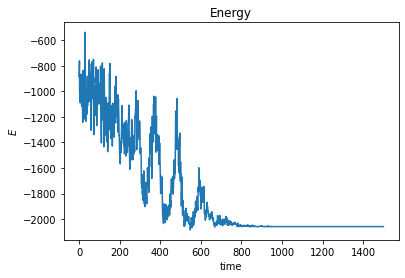

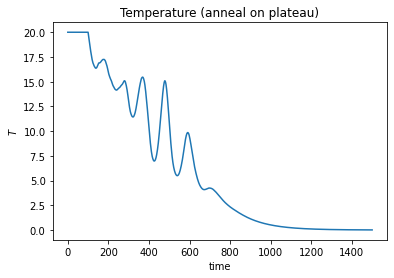

Final temperature: 0.009246065044754798
Minimum energy found by MC: -2084.0


In [20]:
n_spins = 200
num_steps = 1500

'''
uncomment for fixed annealing schedule
you can choose from form = 'const', 'lin', or 'exp'
you can also overlay an oscillation onto it
'''
# cycle = {'p': 300, 'amp': 0.6}
# T = create_fixed_schedule(num_steps, T_i=10, T_f=0.1, form='exp', cycle=cycle)
# run_mc(n_spins, len(T), T)

'''
uncomment for dynamic annealing schedule
there are three types
you can do any of the three individually or you can do plateau and greener grass at the same time
'''

T = 20
run_mc(n_spins, num_steps, T, do_anneal_on_plateau=False, do_greener_grass=False, do_gradient_based=True)

# The Fully Connected Mattis Model

Another model of interest is the Mattis Model which is a specific instance of a Random Bond Ising Model:

$$H = J\sum_{i<j} B_{ij}\sigma_i\sigma_j$$

however, the random bonds take the form:

$$B_{ij} = -\xi_i \xi_j$$

where $\xi_i = \pm 1$ with the sign selected randomly (uniformly) when the model is initialized.

In [21]:
class FullyConnectedMattisModel(FullyConnectedRandomBondIsing):
    def __init__(self, N, J=1.):
        self.J, self.N = J, N
        self.num_spins = self.N
        
        self.xi = 2*(np.random.rand(self.N) < 0.5) - 1
        
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.N) < 0.5) - 1
    
        self.bonds = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(i+1, self.N):
                self.bonds[i, j] = -self.xi[i] * self.xi[j]
    

In [22]:
ising = FullyConnectedMattisModel(10, J=1)
ising.spins

array([-1,  1,  1,  1, -1, -1, -1, -1,  1, -1])

In [23]:
ising.bonds

array([[ 0.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.],
       [ 0.,  0.,  1., -1., -1., -1., -1., -1., -1.,  1.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1., -1.],
       [ 0.,  0.,  0.,  0., -1., -1., -1., -1., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0., -1., -1., -1., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [24]:
ising.energy()

5.0

In [25]:
T = 0.1
# perform 1000 MC steps at low temperature to find the ground state
# it's fairly easy to find in this case as we'll discuss soon
for t in range(1000+1):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=T)
    
    if t % 50 == 0:
        print(E)

-27.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0
-45.0


In [26]:
ising.spins

array([ 1, -1,  1, -1, -1, -1, -1, -1, -1,  1])

In [27]:
def get_bf_min(ising):
    assert ising.num_spins <= 23, "Woah hold up there... You can't do brute force with that many spins."
    dim = np.arange(2 ** ising.num_spins)
    space = ((dim[:, None] & (1 << np.arange(ising.num_spins))) > 0)
    space = 2*space.astype(int) - 1
    return np.einsum("bi,ij,bj->b", space, ising.bonds, space).min()

get_bf_min(ising)

-45.0

While at first glance the `bonds` matrix for the Mattis Model appears to produce the glassy model, it is in fact not a glass at all. We can convert this into a simple fully connected Ising Model using a *gauge transformation*.
But first, make sure the MC simulation has converged to the ground state energy we computed exactly in the previous cell. If it hasn't done so yet, let it run a few more times.

Now let's look at our ground state spin configuration:

In [28]:
ising.spins

array([ 1, -1,  1, -1, -1, -1, -1, -1, -1,  1])

Next we'll look at the Mattis parameters $\xi$

In [29]:
ising.xi

array([ 1, -1,  1, -1, -1, -1, -1, -1, -1,  1])

If we did indeed find the ground state, the spins should match with $\xi$ (upto a global sign). This gives us a hint as to what this Mattis Model actually is.

Let's look again at the Hamiltonian:

$$H = J \sum_{i<j} B_{ij} \sigma_i \sigma_j = -J\sum_{i < j} \xi_i \xi_j \sigma_i \sigma_j = -J\sum_{i < j} (\xi_i \sigma_i) (\xi_j\sigma_j)$$

We introduce some new variables $s_i = \xi_i \sigma_i \in \lbrace 0, 1 \rbrace$. Then our Hamiltonian becomes:

$$H = -J \sum_{i < j} s_i s_j$$

which is just a fully connected Ising Model. If we compute $s_i$ for the state found in the previous simulation, we get:

In [30]:
ising.spins * ising.xi

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

which is one of the ground states of the fully connected Ising Model.

As an (unmarked) bonus problem, you can apply the annealing algorithm you developed in the two previous parts to this model. 
At the end of the annealing procedure, confirm that you've found the ground state by checking that $\xi_i$ is equal to $\sigma_i$ upto a global sign.

### Challenge 1
The cell below is succesful with any of the proposed number of spins. Just change `n_spins` to test it out.

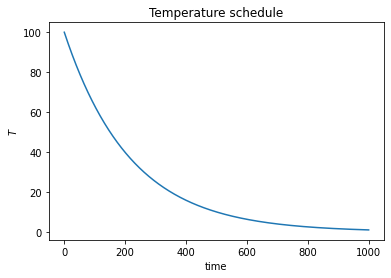

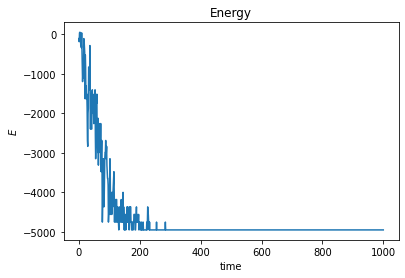

Minimum energy found by MC: -4950.0
Success:  True


In [31]:
# ditched the dynamic annealing here
def run_mc(ising, num_steps, T):
    # get minimum energy by brute force (for small enough systems)
    if ising.num_spins <= 23:
        bf_min = get_bf_min(ising)
        print(f"Minimum energy found by brute force: {bf_min}")
    # perform MC steps
    Es = []
    for t in range(num_steps):
        E = ising.mc_step(T=T[t])
        Es.append(E)
    plot_energy(Es)
    print(f"Minimum energy found by MC: {min(Es)}")
    print("Success: ", abs(sum(ising.spins / ising.xi)) == len(ising.spins))


n_spins = 100
num_steps = 1000

# uncomment for fixed annealing schedule
T = create_fixed_schedule(num_steps, T_i=100, T_f=1, form='exp')
ising = FullyConnectedMattisModel(n_spins, J=1.)
run_mc(ising, len(T), T)